<a href="https://colab.research.google.com/github/Leorev01/Machine-Learning/blob/main/Crime_Data_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

mynameisleo123_crimedata2_path = kagglehub.dataset_download('mynameisleo123/crimedata2')

print('Data source import complete.')


## This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 4.5 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.3-py2.py3-none-any.whl size=317840629 sha256=c805d53745617fd782f397a893a65dcef0a02606fe64ff12bc3d175384e29e40
  Stored in directory: /root/.cache/pip/wheels/1b/3a/92/28b93e2fbfdbb07509ca4d6f50c5e407f48dce4ddbda69a4ab
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder \
    .appName("CrimeDataAnalysis") \
    .getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/26 11:03:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
from pyspark.sql.functions import lit, col, regexp_replace
from pyspark.sql import DataFrame

# Base directory where the CSV files are located
base_dir = "/kaggle/input/crimedata2/Dataset"

# List of county names and corresponding file prefixes for loading files
counties = ["derbyshire", "kent", "leicestershire"]
months = [f"{str(month).zfill(2)}" for month in range(1, 13)]

# Function to load and add a county column to each DataFrame
def load_monthly_data(county: str, month: str) -> DataFrame:
    path = f"{base_dir}/2022-{month}-{county}-street.csv"
    df = spark.read.csv(path, header=True, inferSchema=True)
    df = df.withColumn("County", lit(county.capitalize()))  # Add a standard County column
    return df

# Load and union all the monthly files into one DataFrame
dfs = [load_monthly_data(county, month) for county in counties for month in months]
crime_data = dfs[0]
for df in dfs[1:]:
    crime_data = crime_data.union(df)

# Standardize the County names if needed
crime_data = crime_data.withColumn(
    "County", regexp_replace(col("County"), "Derbyshire Constabulary", "Derbyshire")
)
crime_data = crime_data.withColumn(
    "County", regexp_replace(col("County"), "Leicestershire Constabulary", "Leicestershire")
)
crime_data = crime_data.withColumn(
    "County", regexp_replace(col("County"), "Kent Police", "Kent")
)

# Show the schema to verify
crime_data.printSchema()
crime_data.show(5)


root
 |-- Crime ID: string (nullable = true)
 |-- Month: timestamp (nullable = true)
 |-- Reported by: string (nullable = true)
 |-- Falls within: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOA code: string (nullable = true)
 |-- LSOA name: string (nullable = true)
 |-- Crime type: string (nullable = true)
 |-- Last outcome category: string (nullable = true)
 |-- Context: string (nullable = true)
 |-- County: string (nullable = false)

+--------------------+-------------------+--------------------+--------------------+---------+---------+--------------------+---------+-----------------+--------------------+---------------------+-------+----------+
|            Crime ID|              Month|         Reported by|        Falls within|Longitude| Latitude|            Location|LSOA code|        LSOA name|          Crime type|Last outcome category|Context|    County|
+------------------

In [ ]:
# Register the DataFrame as a temporary SQL view
crime_data.createOrReplaceTempView("crime_data")

# Total Crimes by County
total_crimes_by_county = spark.sql("""
    SELECT County, COUNT(*) AS TotalCrimes
    FROM crime_data
    GROUP BY County
""")
total_crimes_by_county.show()

# Monthly Crime Trends
monthly_crimes = spark.sql("""
    SELECT County, Month, COUNT(*) AS TotalCrimes
    FROM crime_data
    GROUP BY County, Month
    ORDER BY County, Month
""")
monthly_crimes.show()


# Crime Type Analysis
crime_type_analysis = spark.sql("""
    SELECT County, `Crime type` AS Crime_type, COUNT(*) AS CrimeCount
    FROM crime_data
    GROUP BY County, `Crime type`
    ORDER BY County, CrimeCount DESC
""")
crime_type_analysis.show()



+--------------+-----------+
|        County|TotalCrimes|
+--------------+-----------+
|    Derbyshire|     110805|
|          Kent|     200945|
|Leicestershire|     115179|
+--------------+-----------+



+----------+-------------------+-----------+
|    County|              Month|TotalCrimes|
+----------+-------------------+-----------+
|Derbyshire|2022-01-01 00:00:00|       8991|
|Derbyshire|2022-02-01 00:00:00|       8452|
|Derbyshire|2022-03-01 00:00:00|       9598|
|Derbyshire|2022-04-01 00:00:00|       9409|
|Derbyshire|2022-05-01 00:00:00|      10140|
|Derbyshire|2022-06-01 00:00:00|       9710|
|Derbyshire|2022-07-01 00:00:00|      10017|
|Derbyshire|2022-08-01 00:00:00|       9571|
|Derbyshire|2022-09-01 00:00:00|       8781|
|Derbyshire|2022-10-01 00:00:00|       9205|
|Derbyshire|2022-11-01 00:00:00|       8923|
|Derbyshire|2022-12-01 00:00:00|       8008|
|      Kent|2022-01-01 00:00:00|      16338|
|      Kent|2022-02-01 00:00:00|      15383|
|      Kent|2022-03-01 00:00:00|      17310|
|      Kent|2022-04-01 00:00:00|      17144|
|      Kent|2022-05-01 00:00:00|      17546|
|      Kent|2022-06-01 00:00:00|      17388|
|      Kent|2022-07-01 00:00:00|      17950|
|      Ken

+----------+--------------------+----------+
|    County|          Crime_type|CrimeCount|
+----------+--------------------+----------+
|Derbyshire|Violence and sexu...|     41878|
|Derbyshire|Anti-social behav...|     23038|
|Derbyshire|        Public order|     10198|
|Derbyshire|Criminal damage a...|      8724|
|Derbyshire|         Other theft|      6821|
|Derbyshire|       Vehicle crime|      4669|
|Derbyshire|         Shoplifting|      4237|
|Derbyshire|            Burglary|      3806|
|Derbyshire|               Drugs|      2292|
|Derbyshire|         Other crime|      2053|
|Derbyshire|Possession of wea...|       949|
|Derbyshire|             Robbery|       769|
|Derbyshire|Theft from the pe...|       767|
|Derbyshire|       Bicycle theft|       604|
|      Kent|Violence and sexu...|     83341|
|      Kent|Anti-social behav...|     27904|
|      Kent|Criminal damage a...|     19936|
|      Kent|         Other theft|     14318|
|      Kent|        Public order|     12332|
|      Ken

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

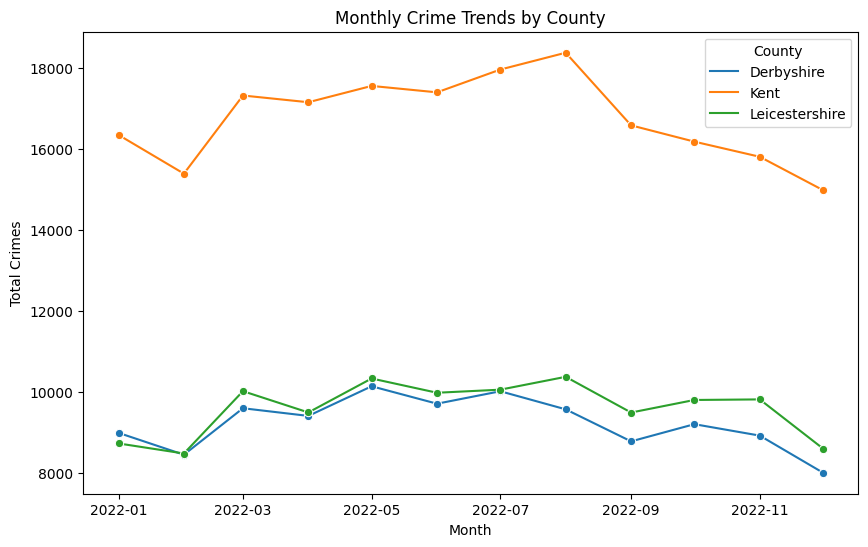

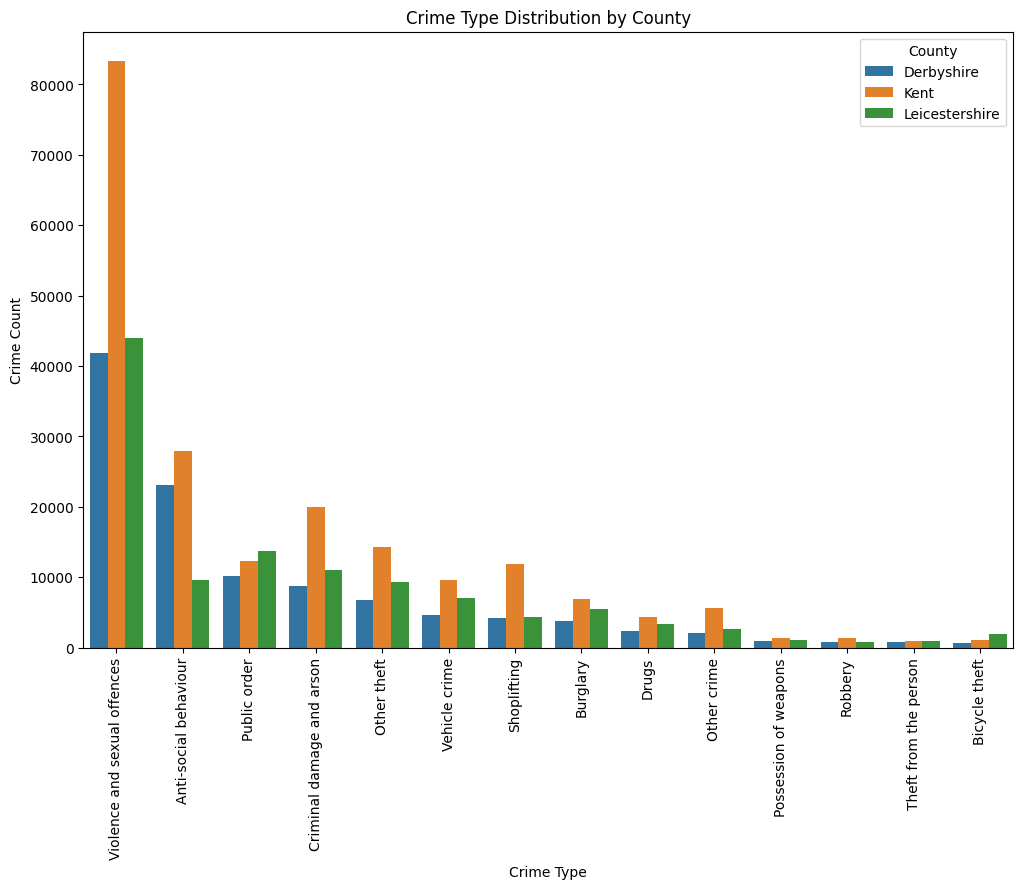

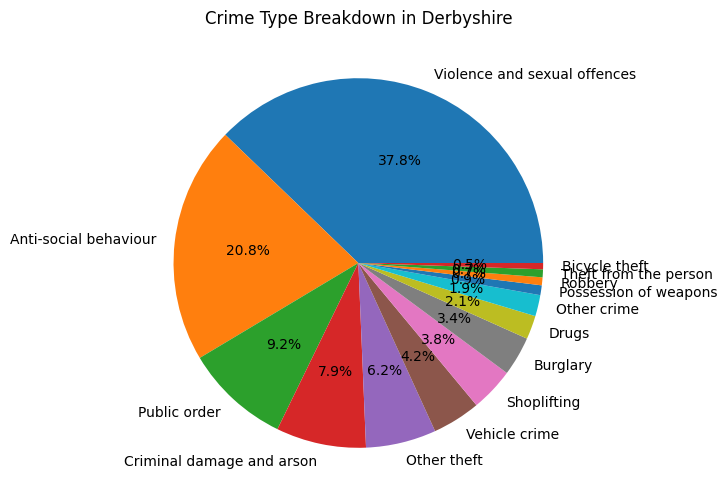

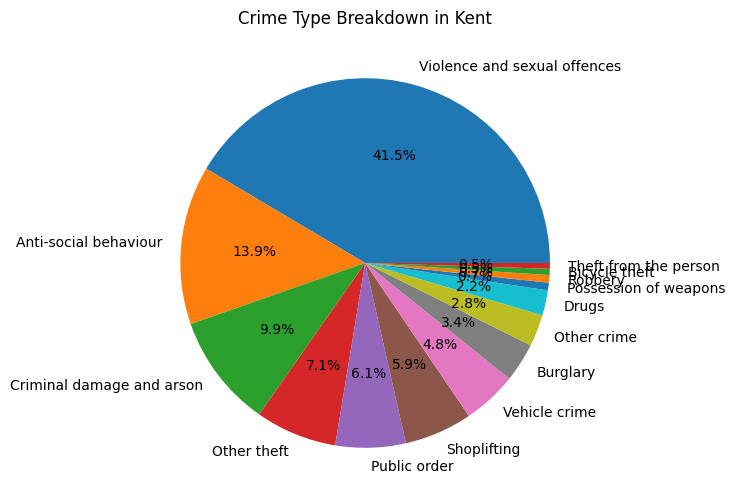

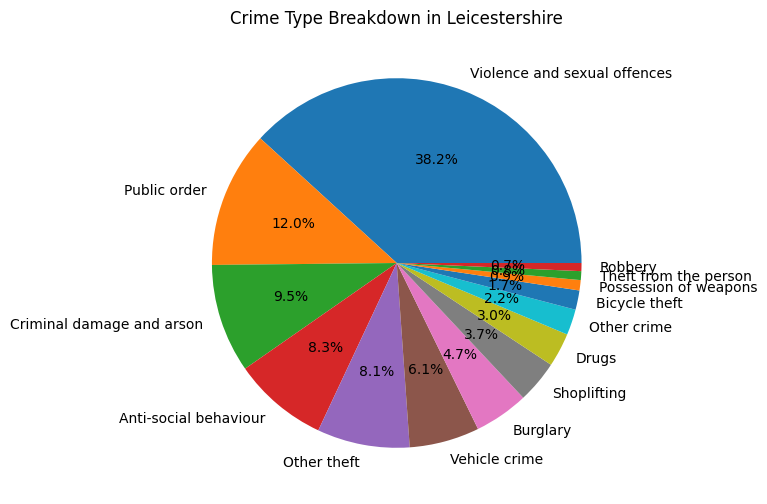

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert Spark DataFrame to Pandas for plotting
total_crimes_df = total_crimes_by_county.toPandas()
monthly_crimes_df = monthly_crimes.toPandas()
crime_type_df = crime_type_analysis.toPandas()

# 1. Line plot for Monthly Crime Trends
plt.figure(figsize=(10, 6))
sns.lineplot(data=monthly_crimes_df, x="Month", y="TotalCrimes", hue="County", marker="o")
plt.title("Monthly Crime Trends by County")
plt.xlabel("Month")
plt.ylabel("Total Crimes")
plt.legend(title="County")
plt.show()

# 2. Bar Chart for Crime Type Distribution
plt.figure(figsize=(12, 8))
sns.barplot(data=crime_type_df, x="Crime_type", y="CrimeCount", hue="County")
plt.xticks(rotation=90)
plt.title("Crime Type Distribution by County")
plt.xlabel("Crime Type")
plt.ylabel("Crime Count")
plt.legend(title="County")
plt.show()

# 3. Pie Charts for Crime Type Breakdown by County
for county in counties:
    data = crime_type_df[crime_type_df['County'] == county.capitalize()]
    plt.figure(figsize=(6, 6))
    plt.pie(data['CrimeCount'], labels=data['Crime_type'], autopct='%1.1f%%')
    plt.title(f"Crime Type Breakdown in {county.capitalize()}")
    plt.show()


In [ ]:
# Summary of Key Insights from Crime Data Analysis

## 1. Total Crime Counts by County
- **Kent** had the highest number of reported crimes, with **200,945** incidents.
- **Derbyshire** followed with **110,805** crimes, while **Leicestershire** reported **115,179** crimes.
- This indicates that Kent has a significantly higher crime rate compared to the other two counties.

## 2. Monthly Crime Trends
- The monthly crime trend analysis shows a fluctuating pattern in total crimes across all counties throughout the year.
- In **Kent**, there were noticeable peaks in crimes around the mid-year months (especially June to August).
- **Derbyshire** exhibited a gradual increase in crime until May, with a slight decrease towards the end of the year.

## 3. Crime Type Distribution
- **Violence and sexual offences** were the most prevalent crime type across all counties, especially in **Kent** (83,341 crimes) and **Derbyshire** (41,878 crimes).
- Other significant crime types included **anti-social behaviour** and **criminal damage and arson**, indicating social issues and property-related concerns.
- **Shoplifting** was also notable, particularly in **Kent**, suggesting retail crime as a significant concern.

## 4. Crime Type Breakdown by County
- Each county has unique crime type distributions:
  - In **Derbyshire**, the second most common crime type was **anti-social behaviour**, while in **Kent**, it was significantly higher at **27,904** crimes.
  - **Leicestershire** showed a more balanced distribution among different crime types, with notable counts across categories such as **criminal damage and arson** and **other theft**.

## Visualizations
- The **line plot** provided a clear visualization of monthly crime trends, illustrating fluctuations in crime rates by county over the year.
- The **bar chart** effectively displayed the distribution of different crime types across the counties, highlighting areas of concern that may require targeted interventions.
- The **pie charts** offered a detailed breakdown of crime types for each county, revealing the dominance of certain categories in specific regions.

## Recommendations
- **Increased Policing in High Crime Areas**: Given the high crime rates in Kent, a focused strategy to address violence and property crimes may be beneficial.
- **Community Engagement**: Initiatives to tackle anti-social behaviour could enhance community safety, particularly in Derbyshire and Kent.
- **Retail Security Improvements**: Strengthening security measures in retail environments could help mitigate the risk of shoplifting, especially in urban areas.

This analysis provides a comprehensive understanding of crime patterns across Derbyshire, Kent, and Leicestershire in 2022, offering actionable insights for law enforcement and community leaders.


SyntaxError: invalid syntax (2168404637.py, line 4)